# Notebook for running the snmachine pipeline on Supernova Photometric Classification Challenge simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed) and the feature extraction methods use least squares here (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [2]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

In [3]:
dataset='spcc'

In [4]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024)

In [5]:
#Data root
rt=os.path.join('SPCC_SUBSET','')

In [6]:
#We can automatically untar the data from here
if not os.path.exists(rt):
    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [7]:
dat=sndata.Dataset(rt)

Reading data...
2000 objects read into memory.


In [8]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


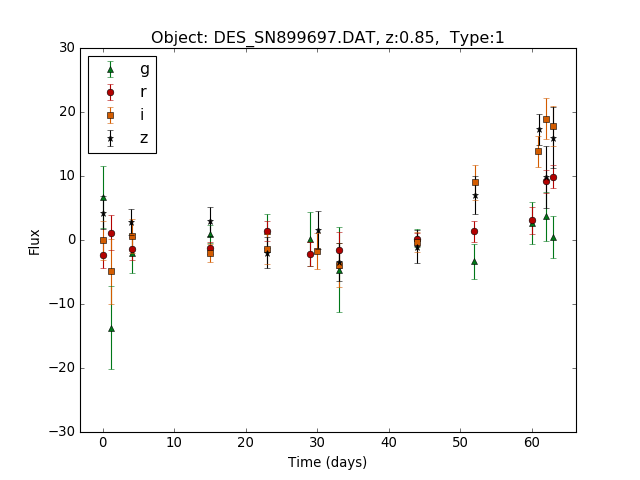

In [9]:
dat.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [10]:
dat.data[dat.object_names[0]]

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,-0.7663,10.48,27.5,ab
0.0160000000033,desr,3.049,7.841,27.5,ab
0.0320000000065,desi,0.4541,9.312,27.5,ab
0.977000000006,desz,4.622,5.329,27.5,ab
1.985,desg,0.8938,3.205,27.5,ab
2.0,desr,3.493,2.427,27.5,ab
2.016,desi,-2.318,4.311,27.5,ab
9.957,desz,39.55,27.34,27.5,ab
10.106,desg,-26.03,25.58,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [11]:
read_from_file=True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'%s_all' %dataset)

### 1. SALT2 Template features

In [12]:
#This is a Features object, not yet the extracted features
#We need to register the LSST bands with sncosmo (which is why lsst_bands=True)
salt2Feats=snfeatures.TemplateFeatures(sampler='leastsq') 

In [13]:
#This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, 
#just set nprocesses>1 for parallelisation.
if read_from_file:
    salt2_features=Table.read('%s_templates.dat' %run_name, format='ascii')
    blah=salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', blah)
else:
    salt2_features=salt2Feats.extract_features(dat,use_redshift=True,nprocesses=4,chain_directory=out_int)
    salt2_features.write('%s_templates.dat' %run_name, format='ascii')

In [14]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
dat.set_model(salt2Feats.fit_sn,salt2_features)

Fitting supernova models...
Models fitted.


<IPython.core.display.Javascript object>


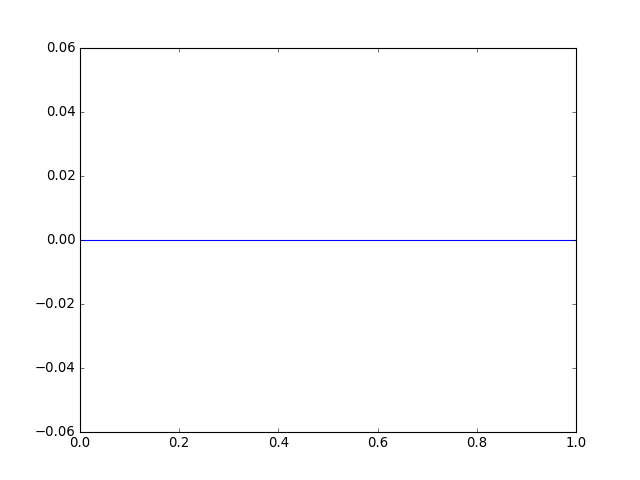

In [15]:
#Now we can see how well the SALT2 model fits our light curves
dat.plot_all()

t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/)

<IPython.core.display.Javascript object>


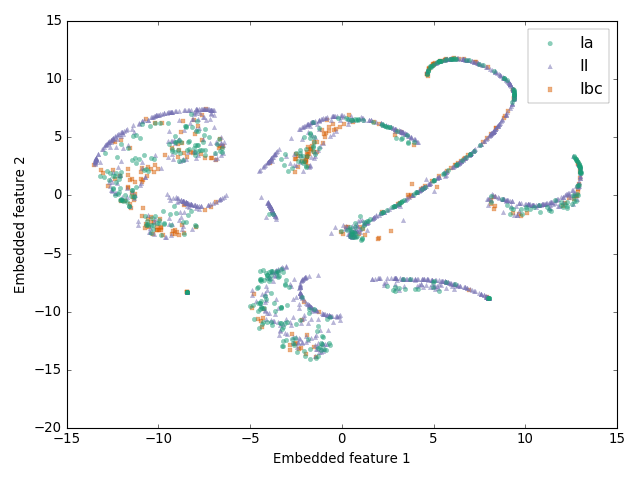

In [16]:
plt.figure()
tsne_plot.plot(salt2_features,join(salt2_features,types)['Type'])

### 2.1 Parametric fits - model 1 (Newling et al.)

In [17]:
mod1Feats=snfeatures.ParametricFeatures('newling',sampler='leastsq')

In [18]:
%%capture --no-stdout
if read_from_file:
    mod1_features=Table.read('%s_newling.dat' %run_name, format='ascii')
    blah=mod1_features['Object'].astype(str)
    mod1_features.replace_column('Object', blah)
else:
    mod1_features=mod1Feats.extract_features(dat,nprocesses=4,chain_directory=out_int)
    mod1_features.write('%s_newling.dat' %run_name, format='ascii')

In [19]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod1_features.colnames[1:]:
    mod1_features[c][np.isnan(mod1_features[c])]=0

In [20]:
dat.set_model(mod1Feats.fit_sn,mod1_features)

Fitting supernova models...
Models fitted.


<IPython.core.display.Javascript object>


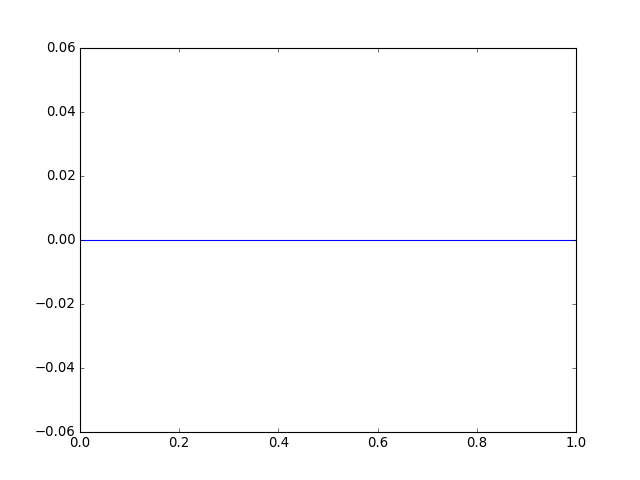

In [21]:
dat.plot_all()

<IPython.core.display.Javascript object>


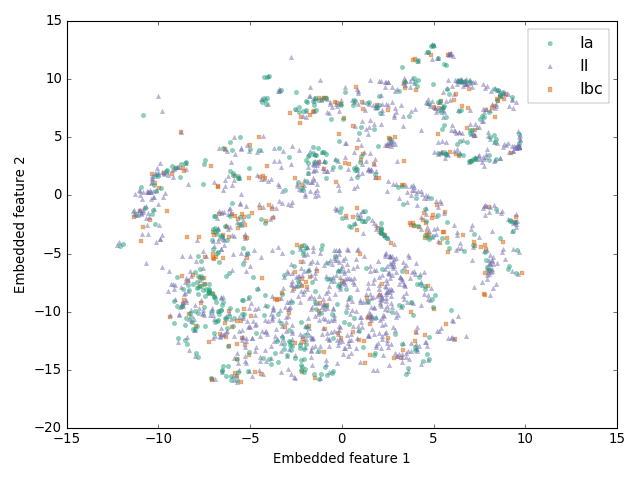

In [22]:
plt.figure()
tsne_plot.plot(mod1_features,join(mod1_features,types)['Type'])

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [23]:
mod2Feats=snfeatures.ParametricFeatures('karpenka',sampler='leastsq')

In [24]:
%%capture --no-stdout
if read_from_file:
    mod2_features=Table.read('%s_karpenka.dat' %run_name, format='ascii')
    blah=mod2_features['Object'].astype(str)
    mod2_features.replace_column('Object', blah)
else:
    mod2_features=mod2Feats.extract_features(dat,nprocesses=4,chain_directory=out_int)
    mod2_features.write('%s_karpenka.dat' %run_name, format='ascii')

In [25]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod2_features.colnames[1:]:
    mod2_features[c][np.isnan(mod2_features[c])]=0

In [26]:
dat.set_model(mod2Feats.fit_sn,mod2_features)

Fitting supernova models...


/home/robert/temp/snmachine/snmachine/parametric_models.py:154: RuntimeWarning: overflow encountered in exp
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))
/home/robert/temp/snmachine/snmachine/parametric_models.py:154: RuntimeWarning: invalid value encountered in true_divide
  return A*(1+B*(t-t1)*(t-t1))*np.exp(-(t-t0)/T_fall)/(1+np.exp(-(t-t0)/T_rise))


Models fitted.


<IPython.core.display.Javascript object>


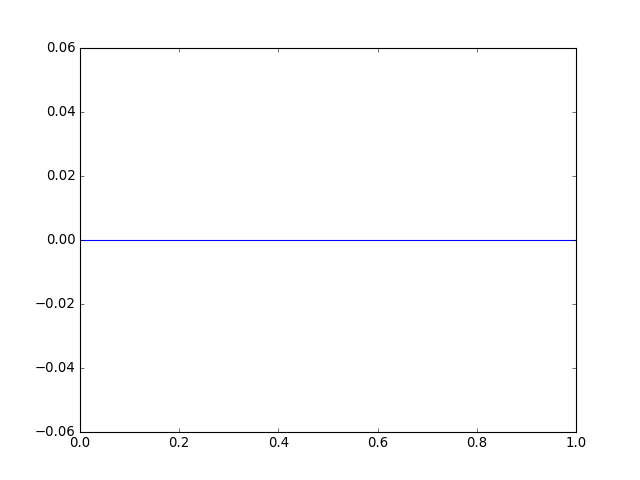

In [27]:
dat.plot_all()

<IPython.core.display.Javascript object>


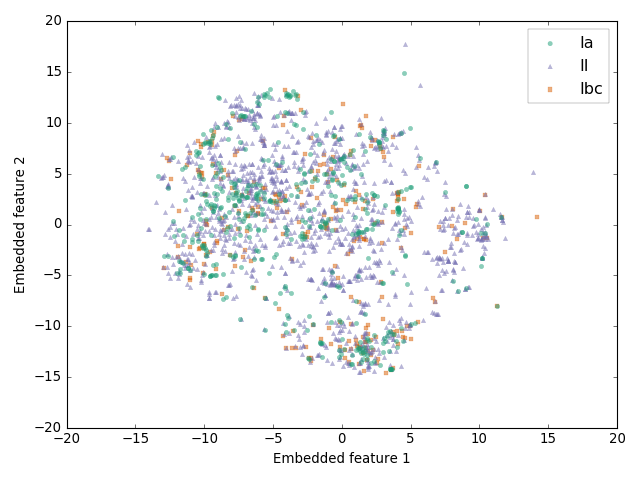

In [28]:
plt.figure()
tsne_plot.plot(mod2_features,join(mod2_features,types)['Type'])

### 3. Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [29]:
waveFeats=snfeatures.WaveletFeatures()

In [30]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
else:
    wave_features=waveFeats.extract_features(dat,nprocesses=4,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

In [31]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

Fitting supernova models...
Models fitted.


<IPython.core.display.Javascript object>


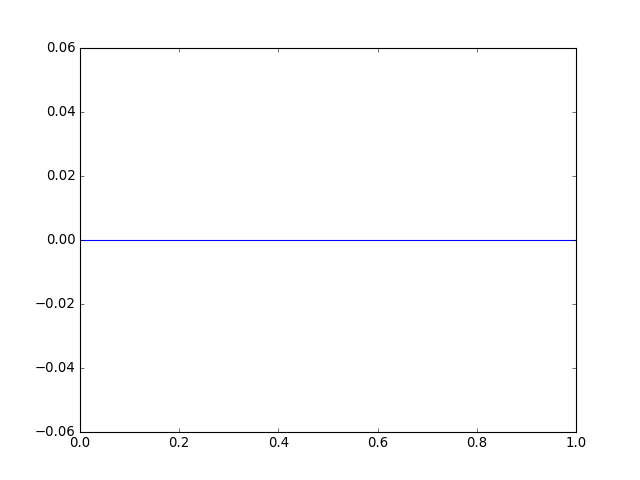

In [32]:
dat.plot_all()

<IPython.core.display.Javascript object>


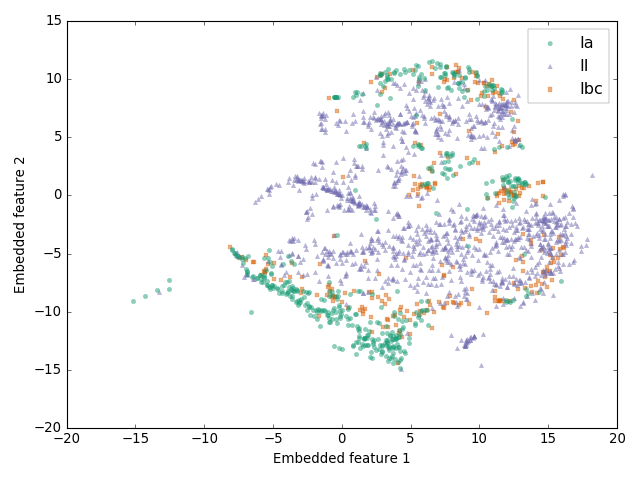

In [33]:
plt.figure()
tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [34]:
nproc=4

In [35]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

['svm', 'knn', 'random_forest', 'decision_tree', 'boost_dt', 'boost_rf', 'nb', 'neural_network']


### 1. SALT2 Template features

<IPython.core.display.Javascript object>


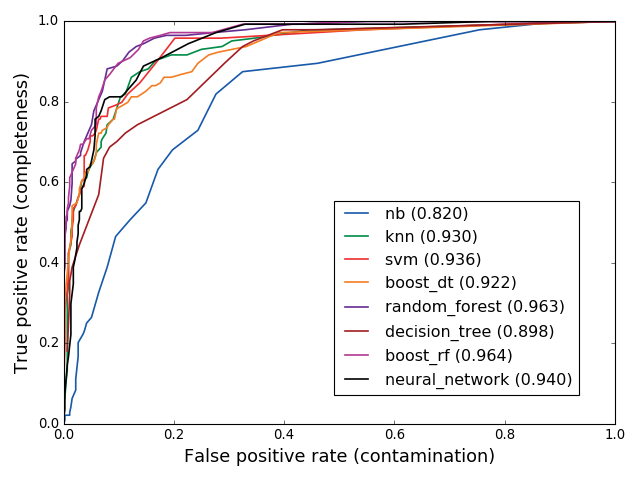

Created classifier of type:
GaussianNB(priors=None)

Created classifier of type:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Optimised parameters: {}
Created classifier of type:
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')




Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4

Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=35,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}




/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'n_estimators': 10, 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)}




/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'criterion': 'entropy', 'n_estimators': 300}


/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'hidden_layer_sizes': (105,)}
Classifier nb: AUC = 0.819886086745 FoM = 0.198471705907


Classifier knn: AUC = 0.92971795809 FoM = 0.398200757576
Classifier svm: AUC = 0.935847648635 FoM = 0.435938527285
Classifier boost_dt: AUC = 0.921867385478 FoM = 0.426767676768


Classifier random_forest: AUC = 0.962650767544 FoM = 0.533574879227
Classifier decision_tree: AUC = 0.898125304581 FoM = 0.323059851088
Classifier boost_rf: AUC = 0.963884320175 FoM = 0.522114347357
Classifier neural_network: AUC = 0.940393518519 FoM = 0.446956264775

Time taken  4.556301506360372 minutes


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [36]:
plt.figure()
clss=snclassifier.run_pipeline(salt2_features,types,output_name=os.path.join(out_class,'salt2'),
                          classifiers=['nb', 'knn', 'svm','boost_dt', 'random_forest', 'decision_tree', 'boost_rf', 'neural_network'], nprocesses=nproc)

### 2.1 Parametric fits - model 1 (Newling et al.)

<IPython.core.display.Javascript object>


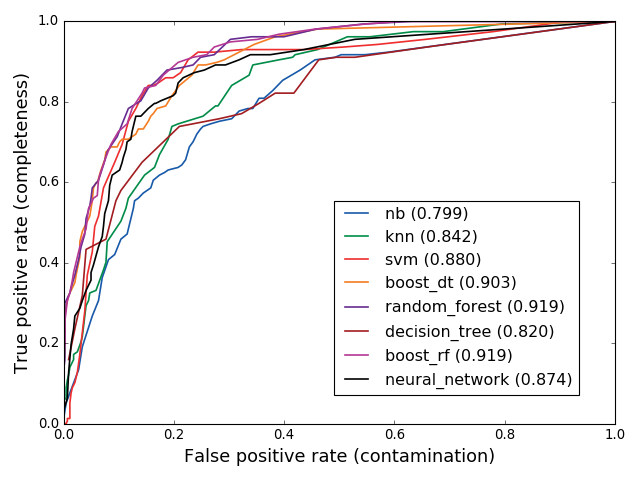

Created classifier of type:
GaussianNB(priors=None)

Created classifier of type:
Created classifier of type:
Created classifier of type:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

Optimised parameters: {}

Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4

Optimised parameters: {'n_estimators': 2, 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)}




/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'criterion': 'entropy', 'n_estimators': 600}


/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Optimised parameters: {'hidden_layer_sizes': (110,)}
Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


Classifier nb: AUC = 0.799478080833 FoM = 0.190884201268
Classifier knn: AUC = 0.841641385458 FoM = 0.231016189675
Classifier svm: AUC = 0.880289284122 FoM = 0.333811787925


Classifier boost_dt: AUC = 0.902639789507 FoM = 0.344071533562
Classifier random_forest: AUC = 0.918628057109 FoM = 0.349772520473


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Classifier decision_tree: AUC = 0.820340469583 FoM = 0.241411715569
Classifier boost_rf: AUC = 0.919311009188 FoM = 0.339350489846
Classifier neural_network: AUC = 0.874207416141 FoM = 0.315188127914

Time taken  9.751150914033254 minutes


In [37]:
plt.figure()
clss=snclassifier.run_pipeline(mod1_features,types,output_name=os.path.join(out_class,'model1'),
                          classifiers=['nb','knn','svm','boost_dt', 'random_forest', 'decision_tree', 'boost_rf', 'neural_network'], nprocesses=nproc)

### 2.2 Parametric fits - model 2 (Karpenka et al.)

<IPython.core.display.Javascript object>


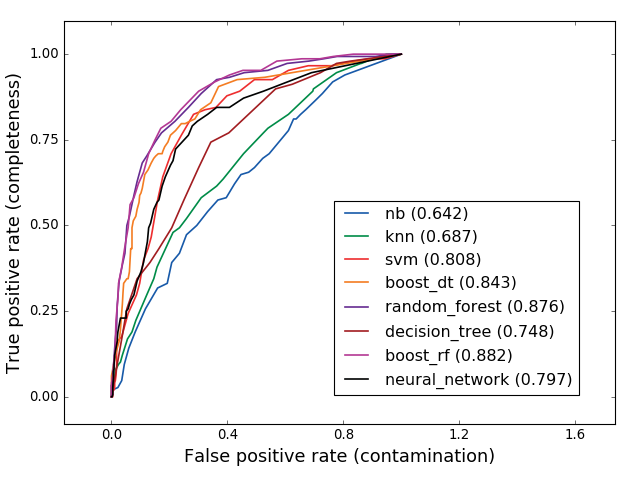

Created classifier of type:
Created classifier of type:
Created classifier of type:
Created classifier of type:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


GaussianNB(priors=None)


Optimised parameters: {}
Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4

Optimised parameters: {'n_estimators': 10, 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)}




/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'criterion': 'gini', 'n_estimators': 700}


/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4

Optimised parameters: {'hidden_layer_sizes': (115,)}
Optimised parameters: {'n_estimators': 65, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}
Classifier nb: AUC = 0.642362772064 FoM = 0.106696248487


Classifier knn: AUC = 0.686902056924 FoM = 0.112183997283
Classifier svm: AUC = 0.808374192777 FoM = 0.200178717
Classifier boost_dt: AUC = 0.843443554174 FoM = 0.247104247104
Classifier random_forest: AUC = 0.876210834729 FoM = 0.276916260523
Classifier decision_tree: AUC = 0.748452822291 FoM = 0.142185663925
Classifier boost_rf: AUC = 0.881584848122 FoM = 0.272287212586


Classifier neural_network: AUC = 0.797080542932 FoM = 0.192912987801

Time taken  11.683952061335246 minutes


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [38]:
plt.figure()
clss=snclassifier.run_pipeline(mod2_features,types,output_name=os.path.join(out_class,'model2'),
                          classifiers=['nb','knn','svm','boost_dt','random_forest', 'decision_tree', 'boost_rf','neural_network'], nprocesses=nproc)

### 3. Wavelet features

<IPython.core.display.Javascript object>


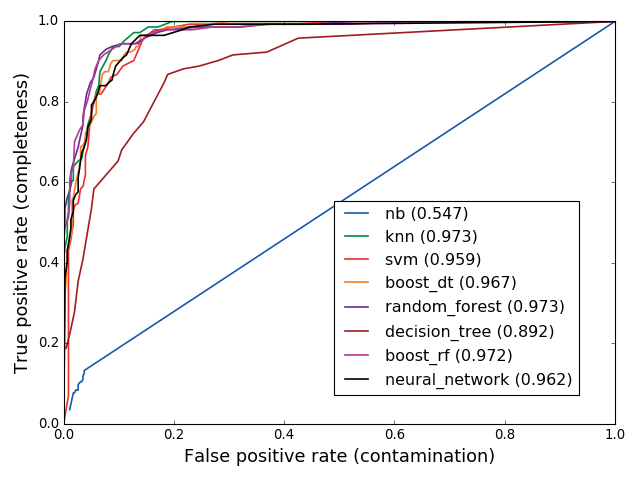

Created classifier of type:
Created classifier of type:
Created classifier of type:
GaussianNB(priors=None)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)Created classifier of type:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)




Optimised parameters: {}
Created classifier of type:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/local/lib/python3.4

Optimised parameters: {'hidden_layer_sizes': (110,)}
Optimised parameters: {'n_estimators': 3, 'base_estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)}
Optimised parameters: {'criterion': 'entropy', 'n_estimators': 600}
Optimised parameters: {'n_estimators': 75, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')}


Classifier nb: AUC = 0.547118664717 FoM = 0.0952380

Classifier svm: AUC = 0.958767361111 FoM = 0.485901730877


Classifier boost_dt: AUC = 0.966526559454 FoM = 0.493251173709
Classifier random_forest: AUC = 0.973036976121 FoM = 0.555555555556
Classifier decision_tree: AUC = 0.892178362573 FoM = 0.308176100629
Classifier boost_rf: AUC = 0.971917641326 FoM = 0.560530679934
Classifier neural_network: AUC = 0.961980689571 FoM = 0.493169398907


/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)



Time taken  9.499495605627695 minutes


In [39]:
plt.figure()
clss=snclassifier.run_pipeline(wave_features,types,output_name=os.path.join(out_class,'wavelets'),
                          classifiers=['nb','knn','svm','boost_dt','random_forest', 'decision_tree', 'boost_rf','neural_network'], nprocesses=nproc)